# Import Statements

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Loading the Dataset

In [2]:
# Load the dataset into pandas DataFrame
df = pd.read_csv('indian_fraud_dataset.csv')
df.head(3)

,timestamp,transaction_type,sender_id,receiver_id,amount,location_sender,location_receiver,device_type,is_international,transaction_hour,is_fraud
0,2023-03-23 01:39:00,ATM,UID252169,UID165312,938.54,Jaipur,Pune,Mobile,0,1,0
1,2023-01-19 05:05:00,RTGS,UID462320,UID209404,6020.24,Ahmedabad,Pune,POS,0,5,0
2,2023-07-20 06:29:00,Wallet,UID936861,UID350052,2633.49,Jaipur,Kolkata,POS,0,6,1


In [3]:
# Check the data types of each column
print(df.dtypes)


timestamp             object
transaction_type      object
sender_id             object
receiver_id           object
amount               float64
location_sender       object
location_receiver     object
device_type           object
is_international       int64
transaction_hour       int64
is_fraud               int64
dtype: object


# EDA - Visualizations

is_fraud
0    242888
1      7112
Name: count, dtype: int64


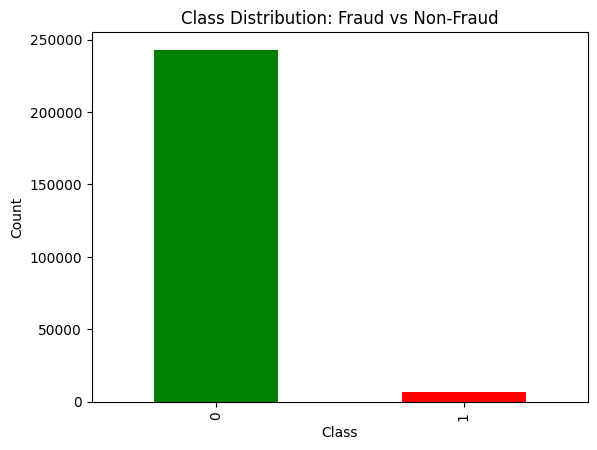

In [4]:
# Check the distribution of fraud and non-fraud cases
print(df['is_fraud'].value_counts())

# Plot the class distribution
import matplotlib.pyplot as plt
df['is_fraud'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Class Distribution: Fraud vs Non-Fraud')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


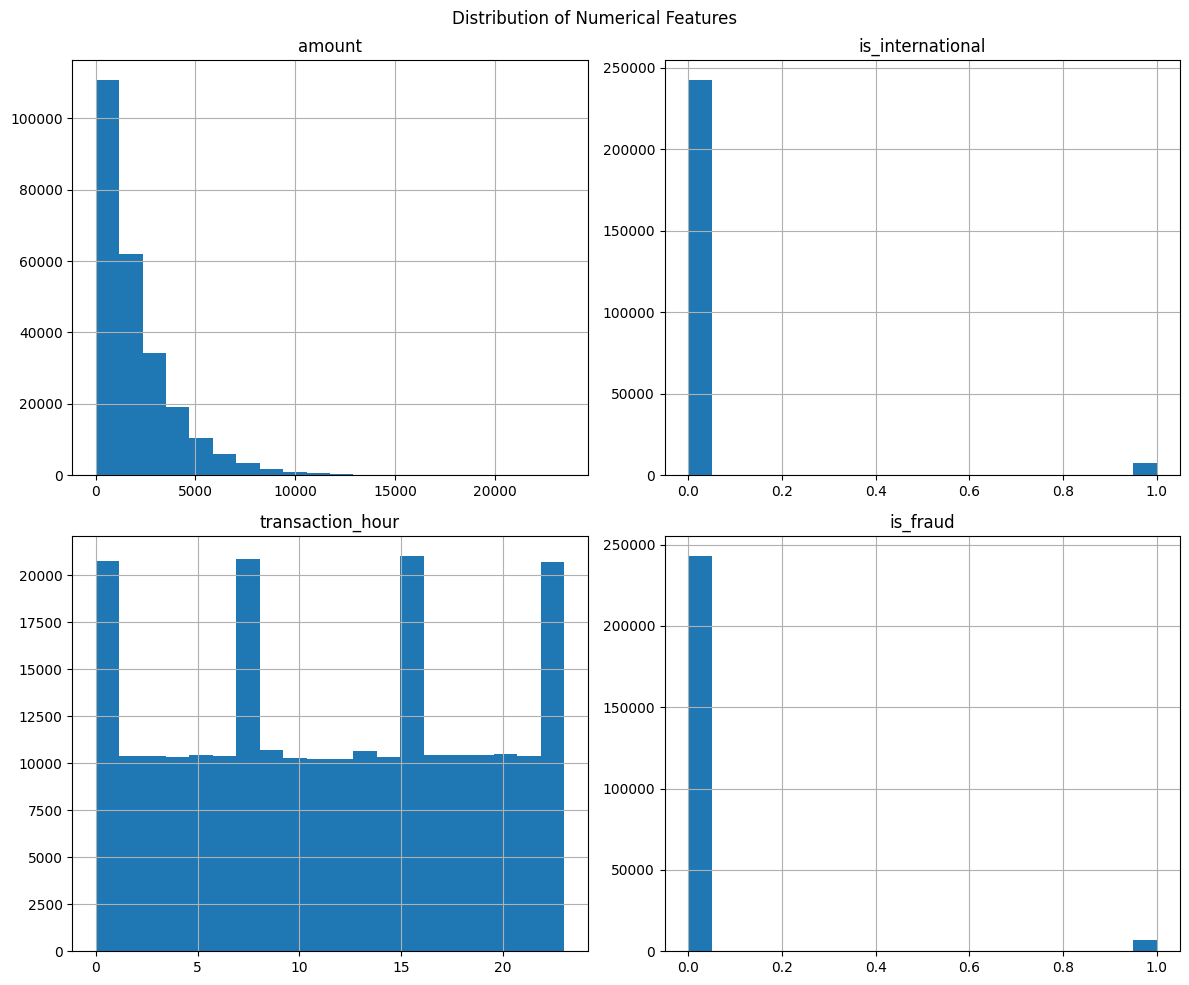

In [5]:
import matplotlib.pyplot as plt

# Automatically select numeric columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Plot histograms
df[numeric_cols].hist(bins=20, figsize=(12, 10))
plt.suptitle('Distribution of Numerical Features')
plt.tight_layout()
plt.show()


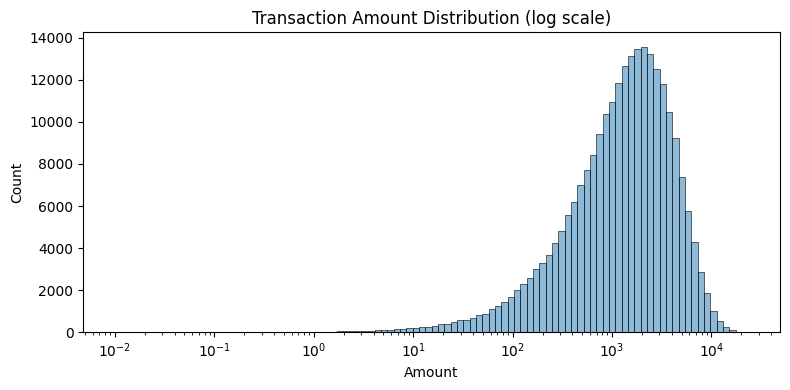

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,4))
sns.histplot(df['amount'], bins=100, log_scale=True, kde=True)
plt.title('Transaction Amount Distribution (log scale)')
plt.xlabel('Amount')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


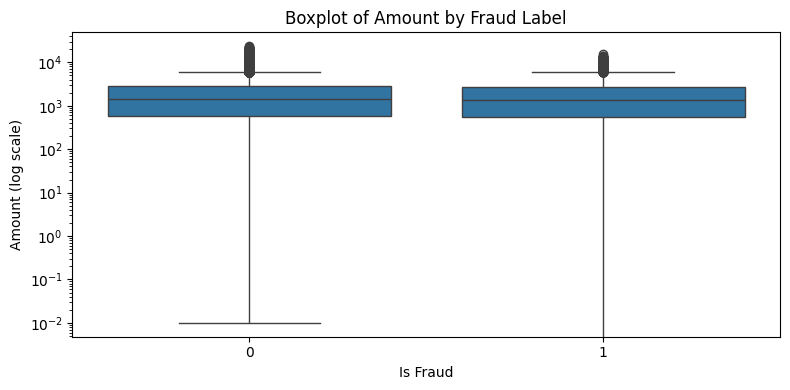

In [7]:
plt.figure(figsize=(8,4))
sns.boxplot(x='is_fraud', y='amount', data=df)
plt.yscale('log')
plt.title('Boxplot of Amount by Fraud Label')
plt.xlabel('Is Fraud')
plt.ylabel('Amount (log scale)')
plt.tight_layout()
plt.show()


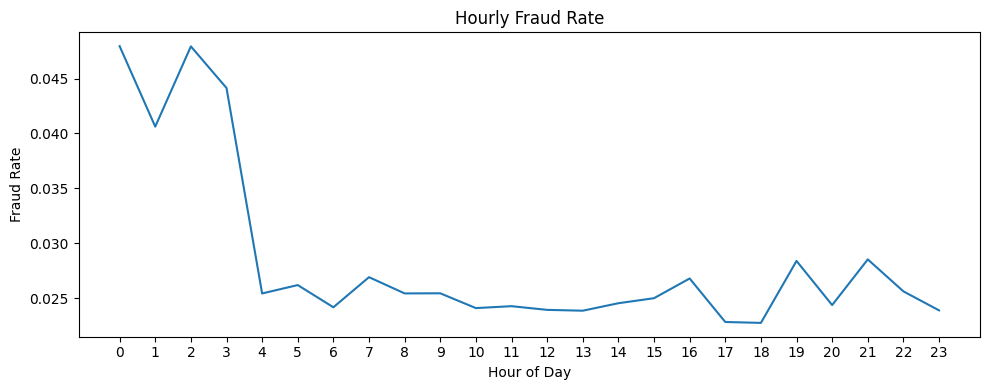

In [8]:
df['timestamp'] = pd.to_datetime(df['timestamp'])  # Ensure 'timestamp' is datetime
df['transaction_hour'] = df['timestamp'].dt.hour  # Extract hour of the day


# Aggregate
hourly = df.groupby(['transaction_hour', 'is_fraud']).size().reset_index(name='count')
pivot = hourly.pivot(index='transaction_hour', columns='is_fraud', values='count').fillna(0)
pivot['fraud_rate'] = pivot[1] / (pivot[0] + pivot[1])

# Plot fraud rate by hour
plt.figure(figsize=(10,4))
sns.lineplot(x=pivot.index, y=pivot['fraud_rate'])
plt.title('Hourly Fraud Rate')
plt.xlabel('Hour of Day')
plt.ylabel('Fraud Rate')
plt.xticks(range(0,24))
plt.tight_layout()
plt.show()


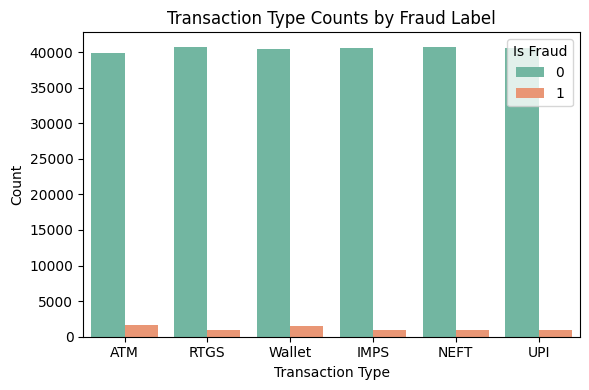

In [9]:
plt.figure(figsize=(6,4))
sns.countplot(x='transaction_type', hue='is_fraud', data=df, palette='Set2')
plt.title('Transaction Type Counts by Fraud Label')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.legend(title='Is Fraud')
plt.tight_layout()
plt.show()


# EDA - Feature Engineering

In [10]:
df.info()
df.describe()

# See unique counts and examples
for col in df.columns:
    print(f"{col} | Unique: {df[col].nunique()} | Sample: {df[col].unique()[:6]}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   timestamp          250000 non-null  datetime64[ns]
 1   transaction_type   250000 non-null  object        
 2   sender_id          250000 non-null  object        
 3   receiver_id        250000 non-null  object        
 4   amount             250000 non-null  float64       
 5   location_sender    250000 non-null  object        
 6   location_receiver  250000 non-null  object        
 7   device_type        250000 non-null  object        
 8   is_international   250000 non-null  int64         
 9   transaction_hour   250000 non-null  int32         
 10  is_fraud           250000 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(2), object(6)
memory usage: 20.0+ MB
timestamp | Unique: 199059 | Sample: <DatetimeArray>
['2023-03-23 01:

In [11]:
df.nunique()

,0
timestamp,199059
transaction_type,6
sender_id,218200
receiver_id,218261
amount,189382
location_sender,10
location_receiver,10
device_type,4
is_international,2
transaction_hour,24


In [12]:
# Parse datetime if it's not parsed
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Create rich time-based features
df['hour'] = df['timestamp'].dt.hour
df['dayofweek'] = df['timestamp'].dt.dayofweek
df['day'] = df['timestamp'].dt.day
df['is_weekend'] = df['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)
df['is_night'] = df['hour'].apply(lambda x: 1 if x <= 6 or x >= 22 else 0)


In [13]:
df['hour_sin'] = np.sin(2 * np.pi * df['transaction_hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['transaction_hour'] / 24)


In [14]:
df['log_amount'] = np.log1p(df['amount'])
df['is_high_amount'] = (df['amount'] > df['amount'].quantile(0.95)).astype(int)

In [15]:
## Same location flag
df['same_location'] = (df['location_sender'] == df['location_receiver']).astype(int)

In [16]:
## Categorize time into periods
def time_period(hour):
    if 5 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 17:
        return 'afternoon'
    elif 17 <= hour < 21:
        return 'evening'
    else:
        return 'night'

df['hour_category'] = df['transaction_hour'].apply(time_period)
df['hour_category'] = df['hour_category'].astype('category').cat.codes


In [17]:
# Create transaction counts per sender/receiver (do this before dropping those columns if needed)
sender_counts = df['sender_id'].value_counts().to_dict()
receiver_counts = df['receiver_id'].value_counts().to_dict()
df['sender_txn_count'] = df['sender_id'].map(sender_counts)
df['receiver_txn_count'] = df['receiver_id'].map(receiver_counts)

In [18]:
from sklearn.preprocessing import LabelEncoder

categorical_cols = ['transaction_type', 'device_type', 'location_sender',
                    'location_receiver', 'hour_category']

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])


In [19]:
# Drop high-cardinality columns
df.drop(['sender_id', 'receiver_id'], axis=1, inplace=True)
df.drop('timestamp', axis=1, inplace=True)


In [20]:
print(f"🧾 Data Shape: {df.shape}")
df.head(3)

🧾 Data Shape: (250000, 21)


,transaction_type,amount,location_sender,location_receiver,device_type,is_international,transaction_hour,is_fraud,hour,dayofweek,...,is_weekend,is_night,hour_sin,hour_cos,log_amount,is_high_amount,same_location,hour_category,sender_txn_count,receiver_txn_count
0,0,938.54,5,9,1,0,1,0,1,3,...,0,1,0.258819,9.659258e-01,6.845390,0,0,3,1,1
1,3,6020.24,0,9,2,0,5,0,5,3,...,0,1,0.965926,2.588190e-01,8.703048,1,0,2,1,1
2,5,2633.49,5,6,2,0,6,1,6,3,...,0,1,1.000000,6.123234e-17,7.876445,0,0,2,1,1


In [21]:
df.info()
df.isnull().sum().sort_values(ascending=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 21 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   transaction_type    250000 non-null  int64  
 1   amount              250000 non-null  float64
 2   location_sender     250000 non-null  int64  
 3   location_receiver   250000 non-null  int64  
 4   device_type         250000 non-null  int64  
 5   is_international    250000 non-null  int64  
 6   transaction_hour    250000 non-null  int32  
 7   is_fraud            250000 non-null  int64  
 8   hour                250000 non-null  int32  
 9   dayofweek           250000 non-null  int32  
 10  day                 250000 non-null  int32  
 11  is_weekend          250000 non-null  int64  
 12  is_night            250000 non-null  int64  
 13  hour_sin            250000 non-null  float64
 14  hour_cos            250000 non-null  float64
 15  log_amount          250000 non-nul

,0
transaction_type,0
amount,0
location_sender,0
location_receiver,0
device_type,0
is_international,0
transaction_hour,0
is_fraud,0
hour,0
dayofweek,0


In [22]:
# Check for duplicate rows
duplicates = df.duplicated().sum()
print(f"Duplicate rows: {duplicates}")


Duplicate rows: 0


# Outliers

In [23]:
from scipy.stats import zscore
# Identify numeric columns
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()

# Compute z‑scores for each numeric column
df_z = df[num_cols].apply(zscore)

# Flag any row that is an outlier in *any* numeric column
outlier_mask = (df_z.abs() > 3).any(axis=1)
df['any_numeric_outlier'] = outlier_mask

print("Rows with any numeric outlier:", df['any_numeric_outlier'].sum())


Rows with any numeric outlier: 42517


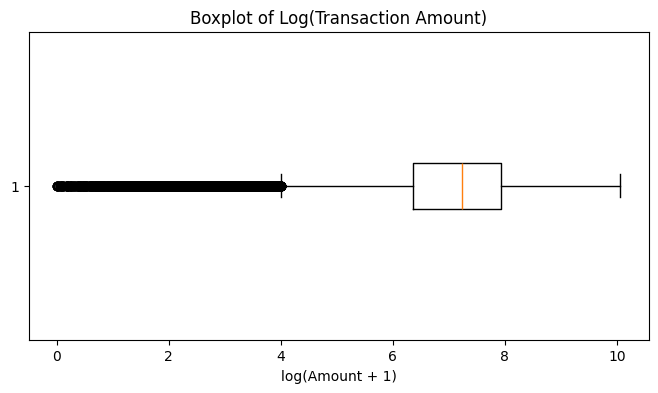

In [24]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.boxplot(np.log1p(df['amount']), vert=False)  # log1p handles 0 safely
plt.title('Boxplot of Log(Transaction Amount)')
plt.xlabel('log(Amount + 1)')
plt.show()


In [25]:
from scipy.stats import zscore
from sklearn.preprocessing import RobustScaler

# 1. Flag per‑col outliers
for col in ['amount']:
    df[f'{col}_z'] = zscore(df[col])
    df[f'{col}_outlier'] = df[f'{col}_z'].abs() > 3

# 2. Winsorize amount
low, high = df['amount'].quantile([0.01, 0.99])
df['amount_capped'] = df['amount'].clip(lower=low, upper=high)

# 3. Robust scale numeric features
scaler = RobustScaler()
nums = ['amount_capped', 'sender_txn_count', 'receiver_txn_count']
df[nums] = scaler.fit_transform(df[nums])


In [26]:
# Summary stats
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
transaction_type,250000.0,NaN,NaN,NaN,2.504156,1.708368,0.0,1.0,3.0,4.0,5.0
amount,250000.0,NaN,NaN,NaN,2002.148775,2000.343396,0.0,574.845,1390.215,2772.995,23482.74
location_sender,250000.0,NaN,NaN,NaN,4.503624,2.870068,0.0,2.0,5.0,7.0,9.0
location_receiver,250000.0,NaN,NaN,NaN,4.493132,2.872013,0.0,2.0,4.0,7.0,9.0
device_type,250000.0,NaN,NaN,NaN,1.502148,1.118878,0.0,0.0,2.0,3.0,3.0
is_international,250000.0,NaN,NaN,NaN,0.030044,0.170709,0.0,0.0,0.0,0.0,1.0
transaction_hour,250000.0,NaN,NaN,NaN,11.506492,6.917904,0.0,6.0,12.0,18.0,23.0
is_fraud,250000.0,NaN,NaN,NaN,0.028448,0.166249,0.0,0.0,0.0,0.0,1.0
hour,250000.0,NaN,NaN,NaN,11.506492,6.917904,0.0,6.0,12.0,18.0,23.0
dayofweek,250000.0,NaN,NaN,NaN,3.004292,2.003368,0.0,1.0,3.0,5.0,6.0


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


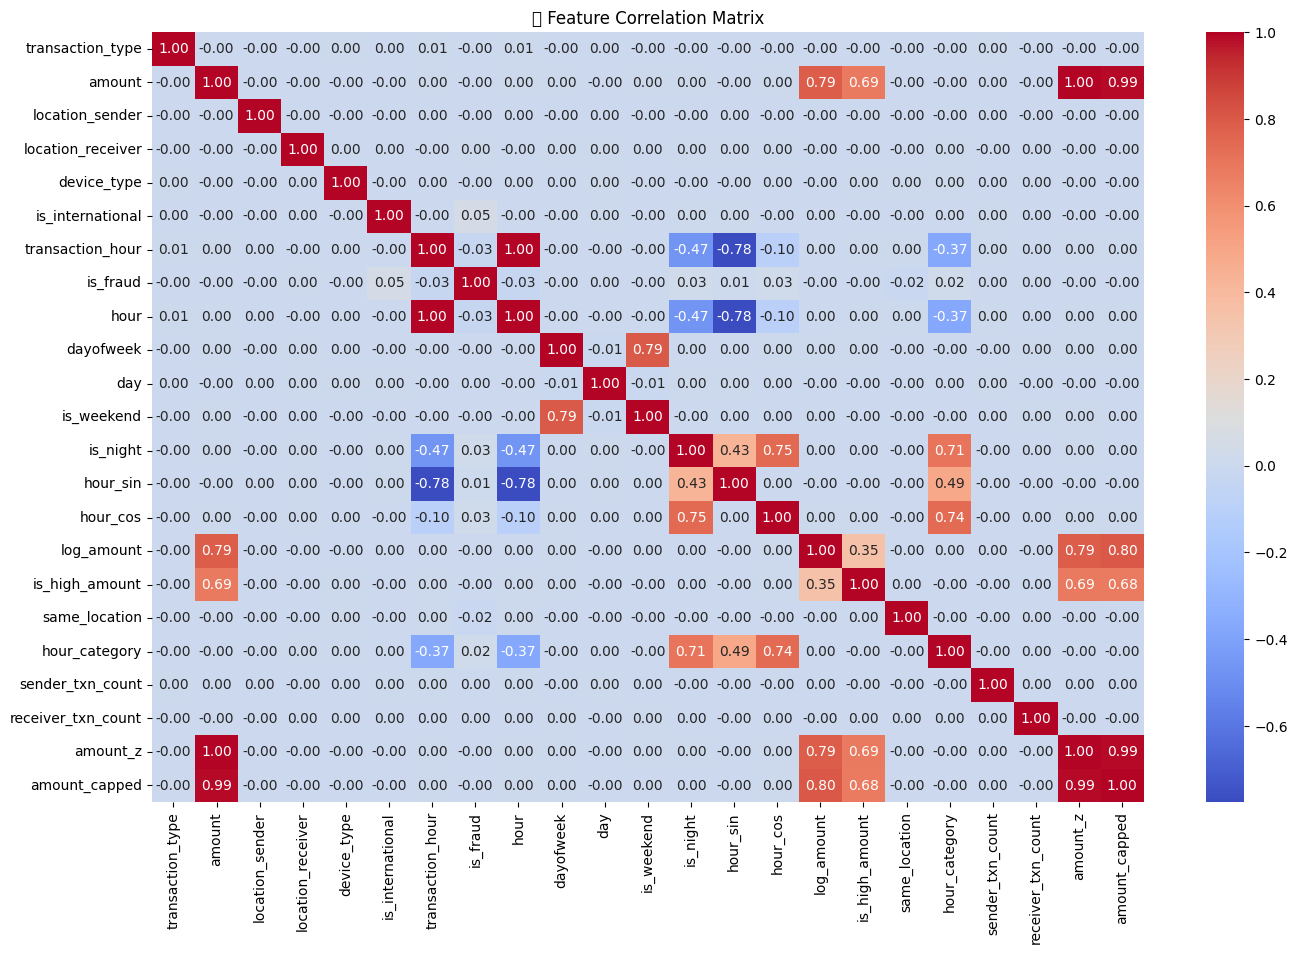

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 10))
sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("🔗 Feature Correlation Matrix")
plt.show()


# Data Split & SMOTE Sampling

In [28]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter

# Step 1: Split the data into training and testing sets
X = df.drop(columns=['is_fraud'])  # Features
y = df['is_fraud']  # Target (fraud or not)

# Split data (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [29]:
# 2. Show original class distribution
print("Before SMOTE:", Counter(y_train))

# 3. Apply SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# 4. Show new class distribution
print("After SMOTE: ", Counter(y_train_res))

# (Optional) also print shapes
print(f"X_train shape: {X_train.shape} → X_train_resampled shape: {X_train_res.shape}")
print(f"y_train shape: {y_train.shape} → y_train_resampled shape: {y_train_res.shape}")

Before SMOTE: Counter({0: 194310, 1: 5690})
After SMOTE:  Counter({0: 194310, 1: 194310})
X_train shape: (200000, 24) → X_train_resampled shape: (388620, 24)
y_train shape: (200000,) → y_train_resampled shape: (388620,)


In [30]:
print(X_train.columns)

Index(['transaction_type', 'amount', 'location_sender', 'location_receiver',
       'device_type', 'is_international', 'transaction_hour', 'hour',
       'dayofweek', 'day', 'is_weekend', 'is_night', 'hour_sin', 'hour_cos',
       'log_amount', 'is_high_amount', 'same_location', 'hour_category',
       'sender_txn_count', 'receiver_txn_count', 'any_numeric_outlier',
       'amount_z', 'amount_outlier', 'amount_capped'],
      dtype='object')


In [31]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)


# Applying IsolationForest

In [32]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(contamination=0.03, random_state=42)
y_pred_iso = iso_forest.fit_predict(X_test_scaled)

# Convert predictions: -1 = outlier, 1 = inlier → fraud = 1, not fraud = 0
y_pred_iso = [1 if x == -1 else 0 for x in y_pred_iso]

print(classification_report(y_test, y_pred_iso))
print(confusion_matrix(y_test, y_pred_iso))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     48578
           1       0.03      0.03      0.03      1422

    accuracy                           0.94     50000
   macro avg       0.50      0.50      0.50     50000
weighted avg       0.94      0.94      0.94     50000

[[47127  1451]
 [ 1373    49]]


In [33]:
from sklearn.ensemble import IsolationForest

# Initialize Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)

# Fit on training data only
iso_forest.fit(X_train_res_scaled)

# Generate anomaly scores (the lower, the more anomalous)
train_anomaly_scores = iso_forest.decision_function(X_train_res_scaled)
test_anomaly_scores = iso_forest.decision_function(X_test_scaled)

# Also get anomaly flags (1 = normal, -1 = outlier)
train_anomaly_flags = iso_forest.predict(X_train_res_scaled)
test_anomaly_flags = iso_forest.predict(X_test_scaled)

# Convert flags from (-1, 1) → (1, 0) for easier interpretation
train_anomaly_flags = (train_anomaly_flags == -1).astype(int)
test_anomaly_flags = (test_anomaly_flags == -1).astype(int)


In [34]:
import numpy as np

# Stack the new features
X_train_with_iso = np.hstack((X_train_res_scaled,
                              train_anomaly_scores.reshape(-1, 1),
                              train_anomaly_flags.reshape(-1, 1)))

X_test_with_iso = np.hstack((X_test_scaled,
                             test_anomaly_scores.reshape(-1, 1),
                             test_anomaly_flags.reshape(-1, 1)))


In [35]:
print("New X_train shape:", X_train_with_iso.shape)
print("New X_test shape:", X_test_with_iso.shape)


New X_train shape: (388620, 26)
New X_test shape: (50000, 26)


# Modelling - Training & Evaluation

## Without using Isolation *Scores*

In [36]:
!pip install catboost

In [37]:
# 1. Imports
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# 2. Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced'),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(),
    "CatBoost": CatBoostClassifier(verbose=0)
}

# 3. Train & evaluate each
for name, model in models.items():
    print(f"\n=== {name} ===")
    # Fit on resampled, scaled training data
    model.fit(X_train_res_scaled, y_train_res)

    # Predict on scaled test data
    y_pred = model.predict(X_test_scaled)

    # Compute AUC if available
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
        print(f"AUC: {roc_auc_score(y_test, y_prob):.4f}")

    # Show precision, recall, F1
    print(classification_report(y_test, y_pred, digits=4))



=== Logistic Regression ===
AUC: 0.9794
              precision    recall  f1-score   support

           0     0.9955    0.9445    0.9693     48578
           1     0.3108    0.8551    0.4559      1422

    accuracy                         0.9419     50000
   macro avg     0.6531    0.8998    0.7126     50000
weighted avg     0.9761    0.9419    0.9547     50000


=== Random Forest ===
AUC: 0.9869
              precision    recall  f1-score   support

           0     0.9947    0.9999    0.9973     48578
           1     0.9949    0.8165    0.8969      1422

    accuracy                         0.9947     50000
   macro avg     0.9948    0.9082    0.9471     50000
weighted avg     0.9947    0.9947    0.9944     50000


=== XGBoost ===


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:20:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


AUC: 0.9891
              precision    recall  f1-score   support

           0     0.9949    0.9999    0.9974     48578
           1     0.9941    0.8242    0.9012      1422

    accuracy                         0.9949     50000
   macro avg     0.9945    0.9120    0.9493     50000
weighted avg     0.9949    0.9949    0.9946     50000


=== LightGBM ===


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 194310, number of negative: 194310
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067686 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2174
[LightGBM] [Info] Number of data points in the train set: 388620, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


AUC: 0.9899
              precision    recall  f1-score   support

           0     0.9949    0.9999    0.9974     48578
           1     0.9941    0.8242    0.9012      1422

    accuracy                         0.9949     50000
   macro avg     0.9945    0.9120    0.9493     50000
weighted avg     0.9949    0.9949    0.9946     50000


=== CatBoost ===
AUC: 0.9895
              precision    recall  f1-score   support

           0     0.9949    0.9998    0.9973     48578
           1     0.9907    0.8242    0.8998      1422

    accuracy                         0.9948     50000
   macro avg     0.9928    0.9120    0.9486     50000
weighted avg     0.9948    0.9948    0.9945     50000



## With Isolation Scores

In [38]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_fscore_support
import pandas as pd

# 1. Define your models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced'),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier()
}

# 2. Prepare your dataset with Isolation Forest features (30 features)
X_tr = X_train_with_iso  # Training data with Isolation Forest features
X_te = X_test_with_iso   # Test data with Isolation Forest features

# 3. Loop over each model
all_results = []

for name, model in models.items():
    # Fit the model
    model.fit(X_tr, y_train_res)
    # Make predictions
    y_pred = model.predict(X_te)
    y_prob = model.predict_proba(X_te)[:,1]
    # Calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred,
                                                                average='binary', zero_division=0)
    auc = roc_auc_score(y_test, y_prob)
    print(f"{name:20s}  AUC: {auc:.4f}  Precision: {precision:.4f}  Recall: {recall:.4f}  F1: {f1:.4f}")
    all_results.append({
        "Model": name,
        "AUC": auc,
        "Precision": precision,
        "Recall": recall,
        "F1": f1
    })

# 4. (Optional) Tabulate results for easy comparison
results_df = pd.DataFrame(all_results)
print("\n\n===== Summary Table =====")
print(results_df.round(4))


Logistic Regression   AUC: 0.9796  Precision: 0.3269  Recall: 0.8347  F1: 0.4698
Random Forest         AUC: 0.9859  Precision: 0.9872  Recall: 0.8150  F1: 0.8929


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:25:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost               AUC: 0.9894  Precision: 0.9915  Recall: 0.8235  F1: 0.8997


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 194310, number of negative: 194310
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.064244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2431
[LightGBM] [Info] Number of data points in the train set: 388620, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM              AUC: 0.9897  Precision: 0.9890  Recall: 0.8200  F1: 0.8966


===== Summary Table =====
                 Model     AUC  Precision  Recall      F1
0  Logistic Regression  0.9796     0.3269  0.8347  0.4698
1        Random Forest  0.9859     0.9872  0.8150  0.8929
2              XGBoost  0.9894     0.9915  0.8235  0.8997
3             LightGBM  0.9897     0.9890  0.8200  0.8966


In [39]:
print(X_tr.shape)
print(X_te.shape)

(388620, 26)
(50000, 26)


In [40]:
feature_names = X_train.columns.tolist()
X_train_res_scaled_df = pd.DataFrame(X_train_res_scaled, columns=feature_names)
print(X_train_res_scaled_df.head())

X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_train.columns)
print(X_test_scaled_df.head())



   transaction_type    amount  location_sender  location_receiver  \
0          1.000000  0.879739             1.25                0.4   
1          0.000000  2.200565             1.25                0.8   
2          0.666667  0.101941             0.75                0.4   
3          0.333333 -0.589496            -0.75                1.0   
4         -0.666667  0.772429             0.50               -0.4   

   device_type  is_international  transaction_hour      hour  dayofweek  \
0          0.0               0.0          0.076923  0.076923  -0.666667   
1         -0.5               0.0          0.153846  0.153846   1.000000   
2          1.0               0.0         -0.615385 -0.615385   0.000000   
3          0.5               0.0         -0.615385 -0.615385   0.000000   
4          0.5               0.0          0.846154  0.846154   0.000000   

        day  ...  log_amount  is_high_amount  same_location  hour_category  \
0  0.200000  ...    0.554659             0.0            

In [41]:
# Pick one of the two, depending on what you want:
# Simply drop use_label_encoder completely
final_model = XGBClassifier(eval_metric='logloss', random_state=42)

final_model.fit(X_train_res_scaled, y_train_res)



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)


AUC Score: 0.9891

Classification Report:
              precision    recall  f1-score   support

           0     0.9949    0.9999    0.9974     48578
           1     0.9941    0.8242    0.9012      1422

    accuracy                         0.9949     50000
   macro avg     0.9945    0.9120    0.9493     50000
weighted avg     0.9949    0.9949    0.9946     50000



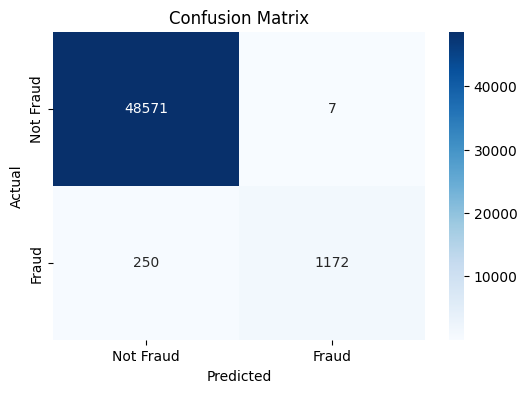

In [42]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict class labels
y_pred = final_model.predict(X_test_scaled)

# Predict probabilities for AUC
y_prob = final_model.predict_proba(X_test_scaled)[:, 1]

# 1. AUC
auc_score = roc_auc_score(y_test, y_prob)
print(f"\nAUC Score: {auc_score:.4f}")

# 2. Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

# 3. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


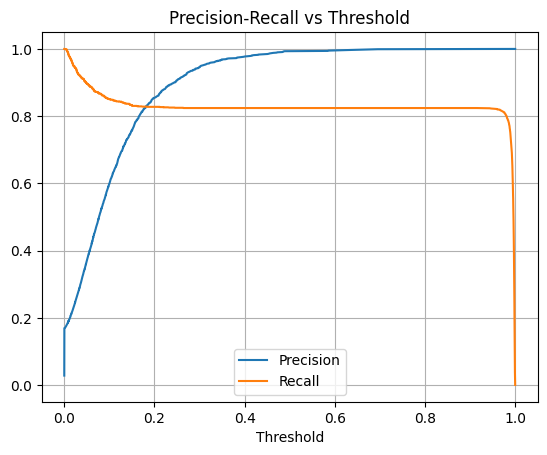

In [43]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel("Threshold")
plt.legend()
plt.title("Precision-Recall vs Threshold")
plt.grid()
plt.show()


In [44]:
recall_target = 0.90
indices = np.where(recall[:-1] >= recall_target)[0]

if len(indices) > 0:
    best_idx = indices[np.argmax(precision[indices])]
    chosen_threshold = thresholds[best_idx]
    print(f"🎯 Best threshold for recall ≥ {recall_target}: {chosen_threshold:.4f}")
    print(f"→ Precision: {precision[best_idx]:.4f}, Recall: {recall[best_idx]:.4f}")
else:
    print(f"No threshold gives recall ≥ {recall_target}")


🎯 Best threshold for recall ≥ 0.9: 0.0481
→ Precision: 0.3607, Recall: 0.9001


In [45]:
import numpy as np

f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)  # add epsilon to avoid division by 0
best_idx = np.argmax(f1_scores)

best_threshold = thresholds[best_idx]
print(f"🔍 Best threshold for highest F1: {best_threshold:.4f}")
print(f"→ Precision: {precision[best_idx]:.4f}, Recall: {recall[best_idx]:.4f}, F1: {f1_scores[best_idx]:.4f}")


🔍 Best threshold for highest F1: 0.9142
→ Precision: 1.0000, Recall: 0.8242, F1: 0.9036


In [46]:
y_pred_custom = (y_prob >= 0.0481).astype(int)

from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report with Custom Threshold:")
print(classification_report(y_test, y_pred_custom, digits=4))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_custom))


Classification Report with Custom Threshold:
              precision    recall  f1-score   support

           0     0.9969    0.9533    0.9746     48578
           1     0.3605    0.9001    0.5148      1422

    accuracy                         0.9517     50000
   macro avg     0.6787    0.9267    0.7447     50000
weighted avg     0.9788    0.9517    0.9615     50000

Confusion Matrix:
[[46307  2271]
 [  142  1280]]


In [47]:
xgb_iso = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_iso.fit(X_train_with_iso, y_train_res)
from sklearn.metrics import classification_report, roc_auc_score

y_pred_iso = xgb_iso.predict(X_test_with_iso)
y_prob_iso = xgb_iso.predict_proba(X_test_with_iso)[:, 1]

print("AUC:", roc_auc_score(y_test, y_prob_iso))
print(classification_report(y_test, y_pred_iso))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:25:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


AUC: 0.9893891703391863
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     48578
           1       0.99      0.82      0.90      1422

    accuracy                           0.99     50000
   macro avg       0.99      0.91      0.95     50000
weighted avg       0.99      0.99      0.99     50000



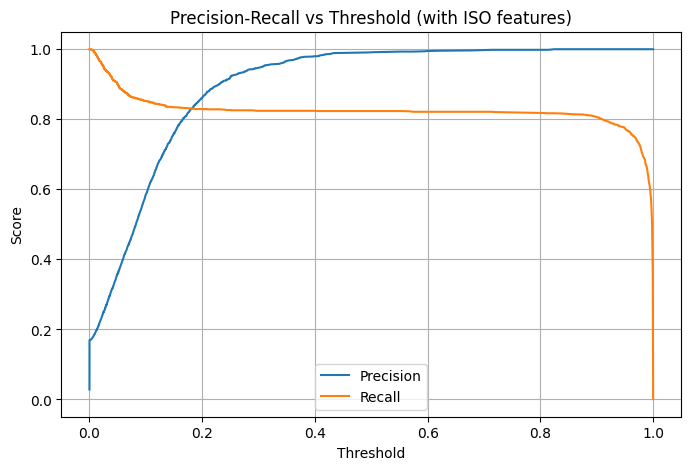


=== XGBoost + Isolation Forest + Threshold=0.033 ===
AUC Score: 0.9894

Classification Report:
              precision    recall  f1-score   support

           0     0.9980    0.9309    0.9633     48578
           1     0.2837    0.9353    0.4354      1422

    accuracy                         0.9310     50000
   macro avg     0.6408    0.9331    0.6993     50000
weighted avg     0.9777    0.9310    0.9482     50000


Confusion Matrix:
[[45220  3358]
 [   92  1330]]


In [48]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np

# 1. Train XGBoost on data WITH Isolation Forest features
xgb_iso = XGBClassifier(eval_metric='logloss')
xgb_iso.fit(X_train_with_iso, y_train_res)

# 2. Predict probabilities on test data (with Isolation Forest features)
y_prob_iso = xgb_iso.predict_proba(X_test_with_iso)[:, 1]

# 3. Optional: Plot Precision vs Recall vs Threshold
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_iso)
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall vs Threshold (with ISO features)")
plt.legend()
plt.grid(True)
plt.show()

# 4. Choose a low threshold (based on above graph or fixed)
low_threshold = 0.033
y_pred_custom_iso = (y_prob_iso >= low_threshold).astype(int)

# 5. Evaluate the performance
print(f"\n=== XGBoost + Isolation Forest + Threshold={low_threshold} ===")
print(f"AUC Score: {roc_auc_score(y_test, y_prob_iso):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_custom_iso, digits=4))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_custom_iso))


## After applying all sorts of techniques to increase recall, came up with two models


In [49]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import joblib

# Train
xgb_no_iso = XGBClassifier(eval_metric='logloss')
xgb_no_iso.fit(X_train_res_scaled, y_train_res)

# Predict
y_prob_no_iso = xgb_no_iso.predict_proba(X_test_scaled)[:, 1]
y_pred_no_iso = (y_prob_no_iso >= 0.5).astype(int)

# Evaluate
print("=== XGBoost WITHOUT ISO ===")
print(f"AUC: {roc_auc_score(y_test, y_prob_no_iso):.4f}")
print(classification_report(y_test, y_pred_no_iso))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_no_iso))

# Save
joblib.dump(xgb_no_iso, "xgb_model_without_iso.pkl")


=== XGBoost WITHOUT ISO ===
AUC: 0.9891
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     48578
           1       0.99      0.82      0.90      1422

    accuracy                           0.99     50000
   macro avg       0.99      0.91      0.95     50000
weighted avg       0.99      0.99      0.99     50000

Confusion Matrix:
 [[48571     7]
 [  250  1172]]


['xgb_model_without_iso.pkl']

In [50]:
# Train
xgb_with_iso = XGBClassifier(eval_metric='logloss')
xgb_with_iso.fit(X_train_with_iso, y_train_res)

# Predict with low threshold
y_prob_with_iso = xgb_with_iso.predict_proba(X_test_with_iso)[:, 1]
y_pred_with_iso = (y_prob_with_iso >= 0.033).astype(int)

# Evaluate
print("\n=== XGBoost WITH ISO + Threshold=0.033 ===")
print(f"AUC: {roc_auc_score(y_test, y_prob_with_iso):.4f}")
print(classification_report(y_test, y_pred_with_iso))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_with_iso))

# Save
joblib.dump(xgb_with_iso, "xgb_model_with_iso_thresh_0033.pkl")



=== XGBoost WITH ISO + Threshold=0.033 ===
AUC: 0.9894
              precision    recall  f1-score   support

           0       1.00      0.93      0.96     48578
           1       0.28      0.94      0.44      1422

    accuracy                           0.93     50000
   macro avg       0.64      0.93      0.70     50000
weighted avg       0.98      0.93      0.95     50000

Confusion Matrix:
 [[45220  3358]
 [   92  1330]]


['xgb_model_with_iso_thresh_0033.pkl']

# SHAP - Explanability

=== SHAP Summary (Without ISO) ===


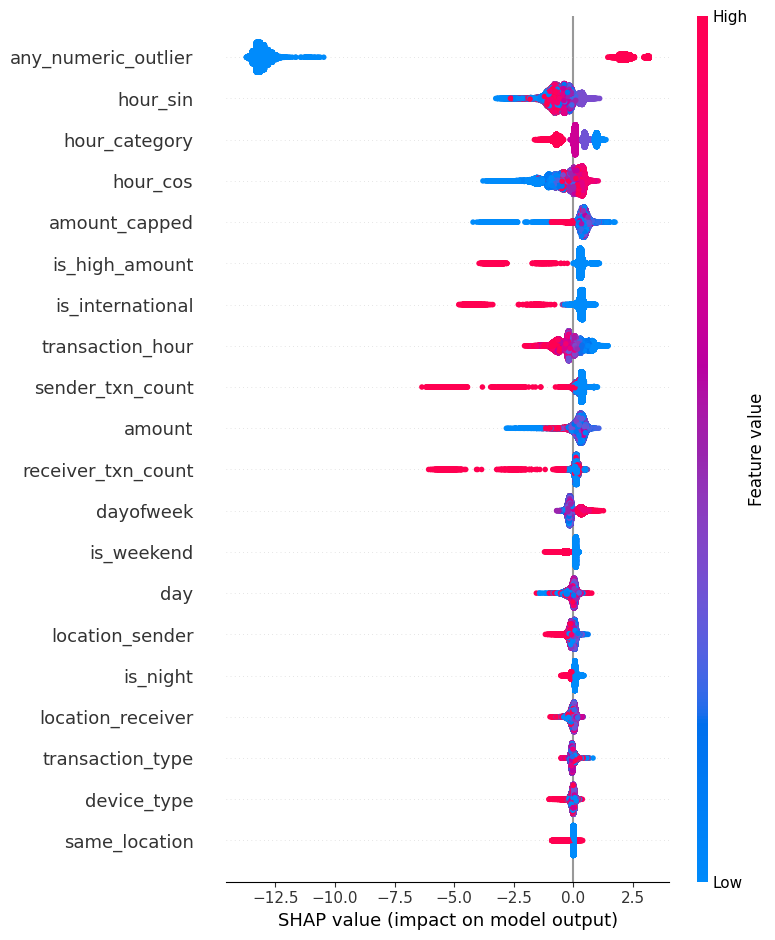

In [51]:
import shap
import joblib

# Load model
xgb_no_iso = joblib.load("xgb_model_without_iso.pkl")

# Get explainer
explainer_no_iso = shap.TreeExplainer(xgb_no_iso)

# Compute SHAP values
shap_values_no_iso = explainer_no_iso.shap_values(X_test_scaled)

# Plot
print("=== SHAP Summary (Without ISO) ===")
shap.summary_plot(shap_values_no_iso, X_test_scaled, feature_names=X_train.columns.tolist())



=== SHAP Summary (With ISO) ===


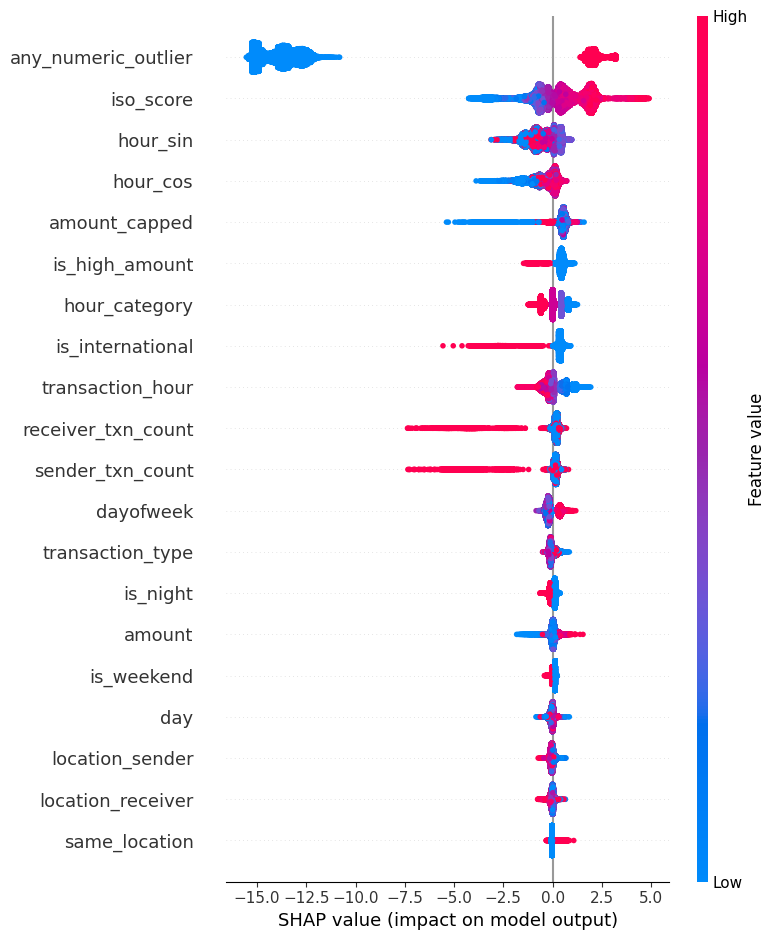

In [52]:
# Load model
xgb_with_iso = joblib.load("xgb_model_with_iso_thresh_0033.pkl")

# Feature names (24 original + 2 new)
feature_names_with_iso = X_train.columns.tolist() + ['iso_score', 'iso_flag']

# Get explainer
explainer_with_iso = shap.TreeExplainer(xgb_with_iso)

# Compute SHAP values
shap_values_with_iso = explainer_with_iso.shap_values(X_test_with_iso)

# Plot
print("=== SHAP Summary (With ISO) ===")
shap.summary_plot(shap_values_with_iso, X_test_with_iso, feature_names=feature_names_with_iso)


=== SHAP Bar Plot (Without ISO Features) ===


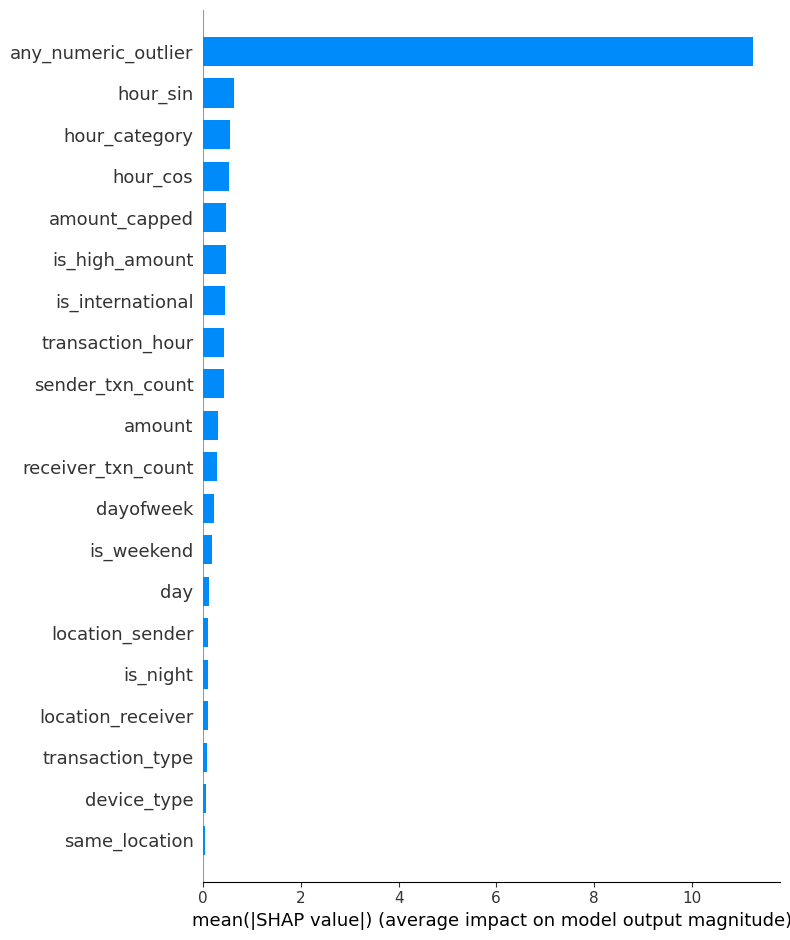

In [53]:
import shap
import joblib

# Load model trained on 24 features
xgb_no_iso = joblib.load("xgb_model_without_iso.pkl")
explainer_no_iso = shap.TreeExplainer(xgb_no_iso)

# SHAP values on test set
shap_values_no_iso = explainer_no_iso.shap_values(X_test_scaled)

# Feature names
feature_names_no_iso = X_train.columns.tolist()

# Bar plot
print("=== SHAP Bar Plot (Without ISO Features) ===")
shap.summary_plot(shap_values_no_iso, X_test_scaled, feature_names=feature_names_no_iso, plot_type="bar")


=== SHAP Bar Plot (With ISO Features) ===


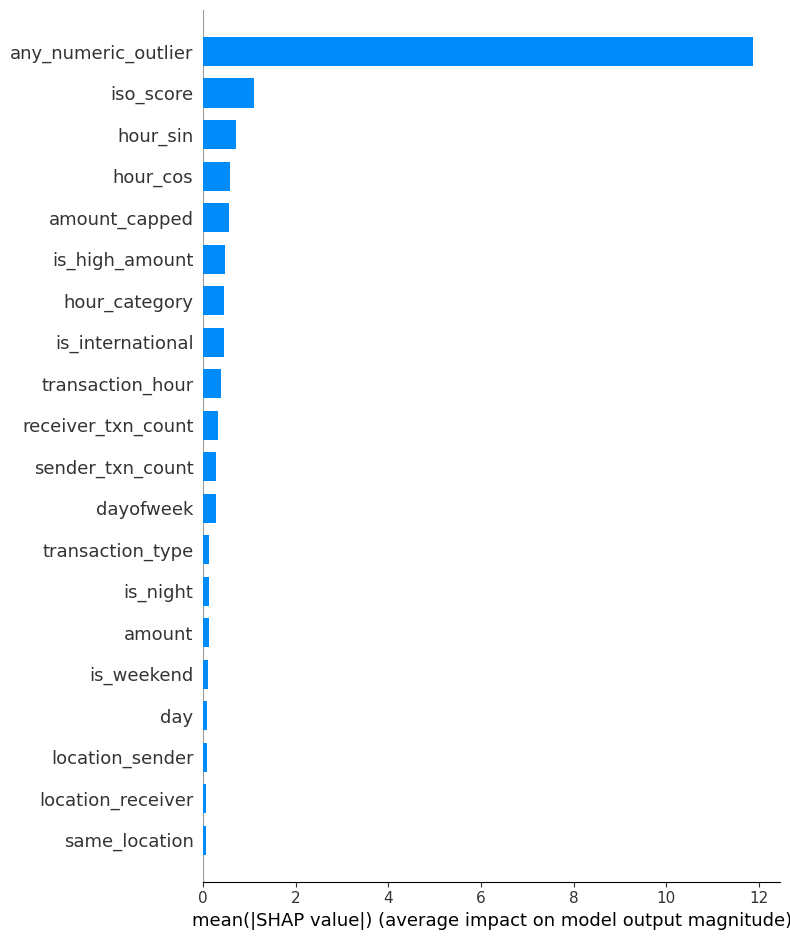

In [54]:
# Load model trained on 26 features
xgb_with_iso = joblib.load("xgb_model_with_iso_thresh_0033.pkl")
explainer_with_iso = shap.TreeExplainer(xgb_with_iso)

# SHAP values on test set
shap_values_with_iso = explainer_with_iso.shap_values(X_test_with_iso)

# Feature names (24 + 2 Isolation Forest)
feature_names_with_iso = X_train.columns.tolist() + ['iso_score', 'iso_flag']

# Bar plot
print("=== SHAP Bar Plot (With ISO Features) ===")
shap.summary_plot(shap_values_with_iso, X_test_with_iso, feature_names=feature_names_with_iso, plot_type="bar")


# Feature Importance

In [55]:
import numpy as np
import pandas as pd
import shap

# Assumes: xgb_no_iso and shap_values_no_iso already computed
shap_importance_no_iso = np.abs(shap_values_no_iso).mean(axis=0)
feature_names_no_iso = X_train.columns.tolist()

feature_importance_no_iso = pd.DataFrame({
    'Feature': feature_names_no_iso,
    'Importance': shap_importance_no_iso
}).sort_values(by='Importance', ascending=False)

print("=== Top 15 Features (Without ISO) ===")
print(feature_importance_no_iso.head(15))



=== Top 15 Features (Without ISO) ===
                Feature  Importance
20  any_numeric_outlier   11.247667
12             hour_sin    0.622551
17        hour_category    0.545983
13             hour_cos    0.537000
23        amount_capped    0.467410
15       is_high_amount    0.466761
5      is_international    0.438489
6      transaction_hour    0.434263
18     sender_txn_count    0.424761
1                amount    0.309219
19   receiver_txn_count    0.274792
8             dayofweek    0.219172
10           is_weekend    0.188234
9                   day    0.125134
2       location_sender    0.098982


In [56]:
# Assumes: xgb_with_iso and shap_values_with_iso already computed
shap_importance_with_iso = np.abs(shap_values_with_iso).mean(axis=0)
feature_names_with_iso = X_train.columns.tolist() + ['iso_score', 'iso_flag']

feature_importance_with_iso = pd.DataFrame({
    'Feature': feature_names_with_iso,
    'Importance': shap_importance_with_iso
}).sort_values(by='Importance', ascending=False)

print("=== Top 15 Features (With ISO) ===")
print(feature_importance_with_iso.head(15))


=== Top 15 Features (With ISO) ===
                Feature  Importance
20  any_numeric_outlier   11.864898
24            iso_score    1.101207
12             hour_sin    0.706774
13             hour_cos    0.574467
23        amount_capped    0.549075
15       is_high_amount    0.478446
17        hour_category    0.442473
5      is_international    0.438899
6      transaction_hour    0.394618
19   receiver_txn_count    0.311601
18     sender_txn_count    0.280739
8             dayofweek    0.273745
0      transaction_type    0.135566
11             is_night    0.132551
1                amount    0.114074


In [57]:
import pandas as pd

# Create a DataFrame to describe all key assets
data = {
    "Purpose": [
        "Training features (without ISO)",
        "Training features (with ISO + 2 features)",
        "Training labels (resampled)",
        "Test features (without ISO)",
        "Test features (with ISO + 2 features)",
        "Test labels (true y)",
        "Prediction probabilities (without ISO)",
        "Prediction probabilities (with ISO)",
        "Final XGBoost model (without ISO)",
        "Final XGBoost model (with ISO + threshold)",
        "Threshold for high-recall fraud detection",
        "SHAP values (without ISO)",
        "SHAP values (with ISO)",
    ],
    "Variable Name": [
        "X_train_res_scaled",
        "X_train_with_iso",
        "y_train_res",
        "X_test_scaled",
        "X_test_with_iso",
        "y_test",
        "y_prob_no_iso",
        "y_prob_iso",
        "xgb_model_no_iso",
        "xgb_model_with_iso",
        "THRESHOLD = 0.033",
        "shap_values_no_iso",
        "shap_values_with_iso",
    ],
    "Notes": [
        "Scaled training set after SMOTE, no Isolation Forest features",
        "Scaled + ISO scores + ISO flags appended (26 features)",
        "Binary labels for SMOTE-resampled training data",
        "Test features with same scaling & features (24 cols)",
        "Test features with added Isolation Forest insights",
        "Ground truth (fraud or not) for model evaluation",
        "Used for AUC, classification report (vanilla model)",
        "Used for custom-threshold classification (recall ↑)",
        "Baseline model, highest F1-score (XGBoost)",
        "Model using Isolation Forest, tuned threshold",
        "Chosen after threshold tuning for fraud recall",
        "Explains predictions of baseline model",
        "Explains predictions of enhanced model"
    ]
}

df_dashboard_summary = pd.DataFrame(data)
print(df_dashboard_summary)


                                       Purpose         Variable Name  \
0              Training features (without ISO)    X_train_res_scaled   
1    Training features (with ISO + 2 features)      X_train_with_iso   
2                  Training labels (resampled)           y_train_res   
3                  Test features (without ISO)         X_test_scaled   
4        Test features (with ISO + 2 features)       X_test_with_iso   
5                         Test labels (true y)                y_test   
6       Prediction probabilities (without ISO)         y_prob_no_iso   
7          Prediction probabilities (with ISO)            y_prob_iso   
8            Final XGBoost model (without ISO)      xgb_model_no_iso   
9   Final XGBoost model (with ISO + threshold)    xgb_model_with_iso   
10   Threshold for high-recall fraud detection     THRESHOLD = 0.033   
11                   SHAP values (without ISO)    shap_values_no_iso   
12                      SHAP values (with ISO)  shap_values_with

# Saving the Model, Features , X_test &  y_test

In [58]:
# Save as CSV
df_dashboard_summary.to_csv("dashboard_variable_summary.csv", index=False)


In [59]:
import joblib
import os

os.makedirs("saved_models", exist_ok=True)

# Models
joblib.dump(xgb_no_iso, "saved_models/xgb_model_without_iso.pkl")
joblib.dump(xgb_with_iso, "saved_models/xgb_model_with_iso_thresh_0033.pkl")

# Test sets
joblib.dump(X_test_scaled, "saved_models/X_test_scaled.pkl")
joblib.dump(X_test_with_iso, "saved_models/X_test_with_iso.pkl")
joblib.dump(y_test, "saved_models/y_test.pkl")

print("✅ Both models and their test data saved for dashboard use.")



✅ Both models and their test data saved for dashboard use.


In [60]:
import pandas as pd
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_fscore_support

# Define your model references and data
models_info = [
    {
        "Name": "XGBoost Without ISO",
        "Model": xgb_no_iso,
        "X_test": X_test_scaled,
        "Threshold": 0.5
    },
    {
        "Name": "XGBoost With ISO + Thresh=0.033",
        "Model": xgb_with_iso,
        "X_test": X_test_with_iso,
        "Threshold": 0.033
    }
]

# Store results
results = []

for info in models_info:
    model = info["Model"]
    X = info["X_test"]
    threshold = info["Threshold"]

    # Get probabilities
    y_prob = model.predict_proba(X)[:, 1]

    # Apply threshold
    y_pred = (y_prob >= threshold).astype(int)

    # Compute metrics
    auc = roc_auc_score(y_test, y_prob)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

    results.append({
        "Model": info["Name"],
        "Threshold": threshold,
        "AUC": round(auc, 4),
        "Precision": round(precision, 4),
        "Recall": round(recall, 4),
        "F1-Score": round(f1, 4)
    })

# Convert to DataFrame
df_metrics = pd.DataFrame(results)

# Save to CSV
df_metrics.to_csv("saved_models/metrics_summary.csv", index=False)
print("✅ Saved metrics_summary.csv in 'saved_models/' folder.")


✅ Saved metrics_summary.csv in 'saved_models/' folder.


In [61]:
# Save dashboard summary
df_dashboard_summary.to_csv("saved_models/df_dashboard_summary.csv", index=False)


In [62]:
import os

os.listdir("saved_models")


['X_test_with_iso.pkl',
 'xgb_model_without_iso.pkl',
 'xgb_model_with_iso_thresh_0033.pkl',
 'metrics_summary.csv',
 'X_test_scaled.pkl',
 'y_test.pkl',
 'df_dashboard_summary.csv']

In [66]:
from google.colab import files
files.download("saved_models/df_dashboard_summary.csv")
files.download("saved_models/xgb_model_without_iso.pkl")
files.download("saved_models/xgb_model_with_iso_thresh_0033.pkl")
files.download("saved_models/X_test_scaled.pkl")
files.download("saved_models/X_test_with_iso.pkl")
files.download("saved_models/y_test.pkl")
files.download("saved_models/metrics_summary.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [64]:
print("✅ All artifacts saved successfully! Models, test data,metrics summary dnd dashboard summary are ready for integration with the Bokeh dashboard. 🚀")


✅ All artifacts saved successfully! Models, test data,metrics summary dnd dashboard summary are ready for integration with the Bokeh dashboard. 🚀
